# Статистический анализ данных сервиса аренды самокатов GoFast

- **Описание**: Цель проекта — провести статистический анализ данных пользователей и их поездок для сервиса аренды самокатов GoFast. В рамках исследования анализируются данные о подписках, поездках и пользователях из разных городов. Основной задачей является выявление паттернов поведения пользователей и проверка гипотез, чтобы помочь бизнесу повысить доходность и оптимизировать маркетинговые стратегии.
- **Задачи исследования**:
    1. Исследовать демографические данные пользователей и их поведенческие паттерны.
    2. Сравнить пользователей с подпиской и без подписки по ключевым показателям (выручка, время и расстояние поездок).
    3. Оценить сезонные колебания выручки для оптимизации маркетинговых активностей.
    4. Проверить гипотезы о поведении пользователей с подпиской и без подписки.
    5. Определить оптимальные параметры для рассылок промокодов и push-уведомлений.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import binom
from scipy.stats import norm

## Загрузка данных

- Загрузим каждый CSV-файл в отдельный датафрейм, используя библиотеку pandas.
- Выведем первые строки каждого датафрейма для знакомства с данными.
- Получим общую информацию о каждом датафрейме, чтобы понять структуру и типы данных.

**Описание данных**:

В основных данных есть информация о пользователях, их поездках и подписках.

- **Пользователи — `users_go.csv`**:
    - `user_id` — уникальный идентификатор пользователя.
    - `name` — имя пользователя.
    - `age` — возраст пользователя.
    - `city` — город проживания пользователя.
    - `subscription_type` — тип подписки (free или ultra).
- **Поездки — `rides_go.csv`**:
    - `user_id` — уникальный идентификатор пользователя.
    - `distance` — расстояние поездки (в метрах).
    - `duration` — продолжительность поездки (в минутах).
    - `date` — дата поездки.
- **Подписки** — **`subscriptions_go.csv`**:
    - `subscription_type` — тип подписки.
    - `minute_price` — стоимость одной минуты поездки для данного типа подписки.
    - `start_ride_price` — стоимость начала поездки.
    - `subscription_fee` — ежемесячная плата за подписку.

In [2]:
# Загрузим данные из датасетов
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# Взглянем на первые строки датафрейма users
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# Взглянем на первые строки датафрейма rides
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
# Взглянем на первые строки датайрейма subscriptions
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
# Изучим общую информацию о датафрейме users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
# Изучим общую информацию о датафрейме rides
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
# Изучим общую информацию о датафрейме subscriptions
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


После загрузки данных мы изучили структуру каждого из датасетов (`users`, `rides`, `subscriptions`) для лучшего понимания информации, с которой будем работать.

Датасет `users`:

- Содержит информацию о пользователях: уникальный идентификатор, имя, возраст, город и тип подписки.
- **Количество записей**: 1565.
- **Пропущенные значения**: Нет пропущенных значений.
- **Типы данных**: числовые (`int64`) для идентификатора и возраста, текстовые (`object`) для имени, города и типа подписки.

Датасет `rides`:

- Включает данные о поездках: идентификатор пользователя, пройденное расстояние, продолжительность поездки и дату.
- **Количество записей**: 18,068.
- **Пропущенные значения**: Нет пропущенных значений.
- **Типы данных**: числовые (`float64` для расстояния и продолжительности, `int64` для идентификатора), текстовый формат для даты (`object`), который требует преобразования для удобства временного анализа.

Датасет `subscriptions`:

- Содержит условия подписки, включая тип подписки, стоимость минуты, стоимость начала поездки и ежемесячную плату.
- **Количество записей**: 2, так как в сервисе доступны только два типа подписки (free и ultra).
- **Пропущенные значения**: Нет пропущенных значений.
- **Типы данных**: числовые (`int64`) для стоимости минуты, стоимости начала поездки и ежемесячной платы, текстовый формат (`object`) для типа подписки.

**Общие наблюдения**

- Датасет `rides` включает большое количество записей.
- Формат даты в `rides` требует преобразования для дальнейшего анализа.
- Данные в `subscriptions` статичны (только 2 типа подписки), что упрощает анализ и использование информации при расчетах выручки.

## Предобработка данных

### Приведем столбец date к типу даты pandas.

In [9]:
# Преобразуем тип колонки date датафрейма rides в datetime
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
# Проверим результат
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Создадим новый столбец с номером месяца на основе столбца date.

In [11]:
# Проверим уникальные годы в данных
rides['year'] = rides['date'].dt.year  # Создаем столбец с годом
unique_years = rides['year'].unique()
print("Уникальные годы в данных:", unique_years)

Уникальные годы в данных: [2021]


В датасете представлены данные только за один год - 2021. Мы можем безопасно использовать столбец `month` для анализа помесячных тенденций.

In [12]:
# Добавим новый столбец содержащий информацию о месяце
rides['month'] = rides['date'].dt.month

In [13]:
# Проверим результат
rides.head()

,user_id,distance,duration,date,year,month
0,1,4409.919140,25.599769,2021-01-01,2021,1
1,1,2617.592153,15.816871,2021-01-18,2021,1
2,1,754.159807,6.232113,2021-04-20,2021,4
3,1,2694.783254,18.511000,2021-08-11,2021,8
4,1,4028.687306,26.265803,2021-08-28,2021,8


### Проверим наличие пропущенных значений

In [14]:
# Проверим наличие пропусков в датафрейме users
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
# Проверим наличие пропусков в датафрейме rides
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
year        0
month       0
dtype: int64

In [16]:
# Проверим наоичие пропусков в датафрейме subscriptions
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Ни в одном из датафреймов не было обнаружено пропущенных значений.

### Проверим наличие дубликатов

In [17]:
# Проверим наличие дубликатов в датафреймах
print(f'Количество дубликатов в датафрейме users: {users.duplicated().sum()}')
print(f'Количество дубликатов в датафрейме rides: {rides.duplicated().sum()}')
print(f'Количество дубликатов в датафрейме subscriptions: {subscriptions.duplicated().sum()}')

Количество дубликатов в датафрейме users: 31
Количество дубликатов в датафрейме rides: 0
Количество дубликатов в датафрейме subscriptions: 0


Дубликаты присустствуют только в датафрейме users. Избавимся от явных дубликатов в этом датасете

In [18]:
# Избавимся от явных дубликатов в датафрейме users
users = users.drop_duplicates()

In [19]:
# Проверим результат
users.duplicated().sum()

0

На этом шаге мы выполнили основные пункты предобработки данных:
- Сконвертировали столбец date в датафрейме rides в datetime
- Добавили новую колонку с порядковым номером месяца
- Проверили наличие пропусков и дубликатов. Избавились от явных дубликатов в данных.

## Исследовательский анализ данных

### Частота встречаемости городов

Для начала подсчитаем, сколько пользователей зарегистрировано в каждом городе. Это поможет понять, где сервис GoFast наиболее популярен.

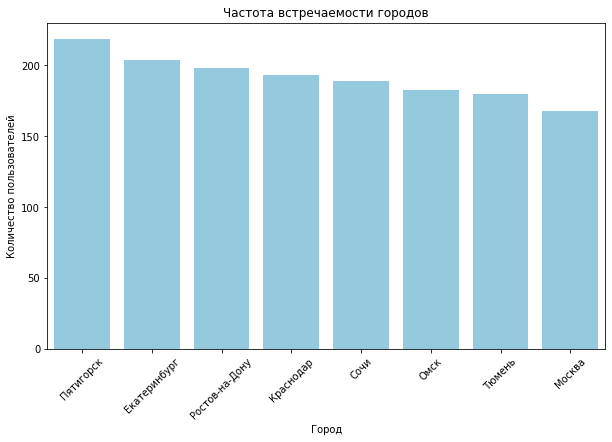

In [20]:
# Подсчет количества пользователей в каждом городе
city_counts = users['city'].value_counts()

# Визуализация: столбчатая диаграмма для частоты встречаемости городов
plt.figure(figsize=(10, 6))
sns.barplot(x=city_counts.index, y=city_counts.values, color='skyblue')
plt.title("Частота встречаемости городов")
plt.xlabel("Город")
plt.ylabel("Количество пользователей")
plt.xticks(rotation=45)
plt.show()

Сервис GoFast имеет стабильное количество пользователей в разных городах, при этом наиболее популярным городом оказался Пятигорск (примерно 220 пользователей), а наименьшая концентрация пользователей наблюдается в Москве (примерно 175 пользователей), что неожиданно, учитывая количество населения в Пятигорске и Москве. Возможно, сервису удалось лучше закрепиться в Пятигорске как раз за счет небольшого размера и меньшей конкуренции по сравнению с Москвой и другими крупными городами. Это может говорить о потенциале для расширения сервиса в крупных городах миллионниках.

##### Соотношение пользователей с подпиской и без подписки

Изучим, какое количество пользователей выбрало подписку Ultra, а какое пользуется сервисом без подписки.

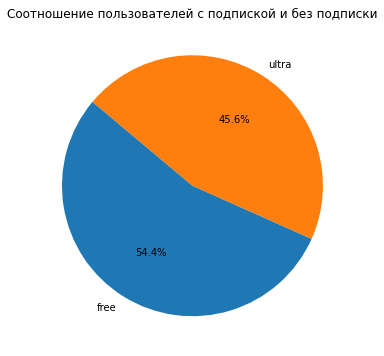

In [21]:
# Подсчет количества пользователей с разными типами подписок
subscription_counts = users['subscription_type'].value_counts()

# Визуализация: круговая диаграмма для соотношения пользователей с подпиской и без подписки
plt.figure(figsize=(6, 6))
plt.pie(subscription_counts, labels=subscription_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Соотношение пользователей с подпиской и без подписки")
plt.show()

Сейчас 45.6% пользователей сервиса используют подписку Ultra, тогда как 54.4% предпочитают пользоваться сервисом без подписки. Это может говорить о  потенциале для роста числа подписчиков при правильном маркетинговом подходе. Возможно, следует более активно продвигать преимущества подписки.

##### Возраст пользователей

Проанализируем возрастную структуру пользователей сервиса, чтобы понять, в каких возрастных группах GoFast наиболее популярен.

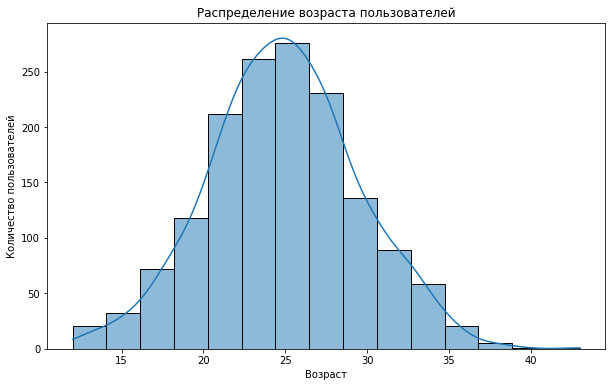

In [22]:
# Визуализация: гистограмма для распределения возраста пользователей
plt.figure(figsize=(10, 6))
sns.histplot(users['age'], bins=15, kde=True)
plt.title("Распределение возраста пользователей")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Большинство пользователей сервиса GoFast находятся в возрастной группе от 20 до 30 лет, что делает её основной целевой аудиторией. Это открывает возможности для более точного маркетинга, направленного на молодёжь и студентов, которые активно пользуются транспортными услугами для перемещений по городу.

##### Расстояние, которое пользователь преодолел за одну поездку

Изучим распределения расстояний за одну поездку. Это даст возможность понять, как далеко обычно ездят пользователи за сессию.

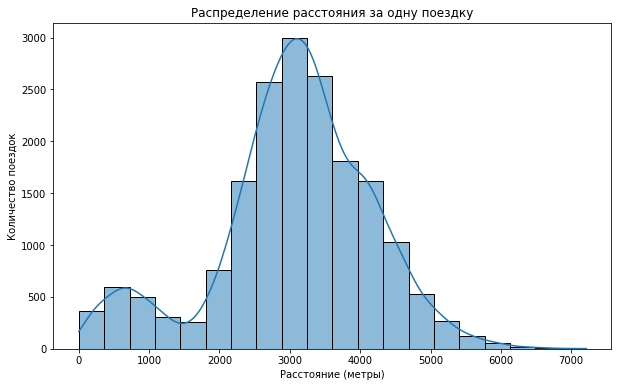

In [23]:
# Визуализация: гистограмма для распределения расстояния за одну поездку
plt.figure(figsize=(10, 6))
sns.histplot(rides['distance'], bins=20, kde=True)
plt.title("Распределение расстояния за одну поездку")
plt.xlabel("Расстояние (метры)")
plt.ylabel("Количество поездок")
plt.show()

Можем наблюдать два пика: первый пик на расстоянии примерно 500 метров, второй на расстоянии 3 км. Это может указывать как на 2 разные модели поведения пользователей, так и на потенциальные ошибки или вбросы, а так же на возможные проблемы с использованием самокатов (например, если пользователи часто начинают и сразу завершают поездку из-за технических проблем). В дальнейшем анализе стоит рассмотреть этот момент подробнее. 
Если отталкиваться от теории разного поведения пользователей на разных дистанциях, можно слелать вывод, что пользователи достаточно часто используют самокаты, чтобы проехать небольшие расстояния как 500 метров (возможно, когда опаздывают), меньше используют самокаты на расстояниях от 1 до 2 километров и активно используют сервис для поездок на расстояния около 3 км.

##### Продолжительность поездок

Изучим продолжительность поездок чтобы понять, сколько времени пользователи обычно проводят в движении, что важно для ценообразования и планирования сервиса.

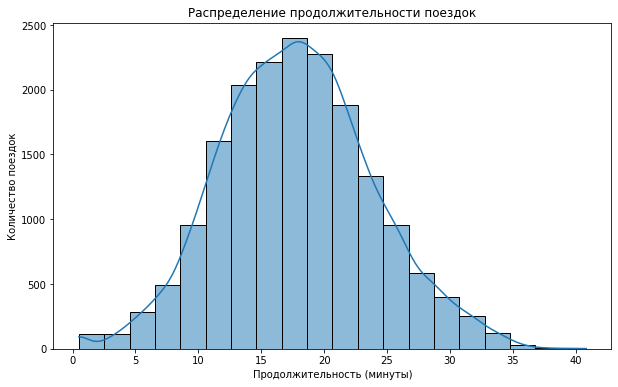

In [24]:
# Визуализация: гистограмма для распределения продолжительности поездок
plt.figure(figsize=(10, 6))
sns.histplot(rides['duration'], bins=20, kde=True)
plt.title("Распределение продолжительности поездок")
plt.xlabel("Продолжительность (минуты)")
plt.ylabel("Количество поездок")
plt.show()

Продолжительность поездок на самокатах GoFast распределяется практически нормально, в основном от 10 до 20 минут, без дополнительных аномальных пиков. Это может говорить о стабильности времени поездок для большинства пользователей. Однако, учитывая гипотезу о коротких поездках на 500 метров, можно предположить, что некоторые пользователи тратят больше времени на короткие дистанции из-за, возможно, разряженных самокатов или других технических факторов. Этот момент может быть полезно дополнительно исследовать, чтобы улучшить пользовательский опыт.

##### Промежуточный вывод

Анализ данных о пользователях и поездках GoFast дает интересные и ценные наблюдения о поведении клиентов и особенностях использования сервиса. Давайте подведем итоги по каждому аспекту:

1. **Города**: Количество пользователей распределено относительно равномерно по городам, но наибольшая концентрация наблюдается в Пятигорске, а наименьшая — в Москве. Это может указывать на хороший уровень проникновения сервиса в небольших городах и потенциальные возможности для роста в крупных мегаполисах. Особенно стоит обратить внимание на привлечение новых пользователей в Москве, где сервис пока недостаточно популярен.
2. **Подписка**: Почти половина пользователей (45.6%) выбрала подписку Ultra, тогда как большинство (54.4%) продолжает пользоваться сервисом без подписки. Это указывает на высокий потенциал для роста числа подписчиков, если активно продвигать преимущества подписки. Возможно, стоит рассмотреть маркетинговые кампании, которые акцентируют выгоды подписки.
3. **Возраст**: Основная возрастная группа пользователей — это люди от 20 до 30 лет. Это закономерный и ожидаемый результат, так как именно молодые люди чаще всего используют мобильные и удобные виды транспорта для коротких поездок по городу. Эта возрастная группа должна стать основной целевой аудиторией при продвижении сервиса и подписок.
4. **Расстояние поездок**: Распределение расстояний поездок имеет два пика — на 500 метров и около 3 км. Первый пик может указывать на частое использование самокатов для очень коротких поездок, что может быть связано с необходимостью быстро преодолеть короткую дистанцию. Однако стоит проверить, не является ли это результатом технических проблем или ошибок в данных. Второй пик на 3 км отражает типичное использование самокатов для средних по длине поездок, что делает сервис удобным и привлекательным для перемещений по городу.
5. **Продолжительность поездок**: Продолжительность поездок имеет нормальное распределение, в основном от 10 до 20 минут. Это говорит о том, что большинство пользователей стабильно укладываются в этот временной интервал. Однако предполагается, что короткие поездки на 500 метров могут иногда занимать больше времени, чем ожидалось, возможно, из-за технических ограничений, таких как низкий заряд самокатов. Этот аспект стоит дополнительно изучить, чтобы улучшить качество обслуживания.

##### Итог:

Анализ показал, что у сервиса GoFast есть устойчивая база пользователей с определенными предпочтениями и паттернами поведения. Основная целевая аудитория — это молодые люди, которые активно пользуются самокатами для поездок от 2,5 до 4 км и продолжительностью 10-20 минут. При этом есть потенциал для роста в крупных городах и для увеличения числа подписчиков. Важно также обратить внимание на технические аспекты, чтобы исключить ситуации, когда пользователи вынуждены тратить больше времени на короткие поездки из-за проблем с оборудованием.

## Объединение данных

### Объединение данных о пользователях, поездках и подписках

Объединим данные пользователей и поездок, затем добавим информацию о подписках.

In [25]:
# Объединяем данные пользователей и поездок по user_id
user_rides = users.merge(rides, on='user_id', how='inner')

# Объединяем полученные данные с информацией о подписках по subscription_type
all_data = user_rides.merge(subscriptions, on='subscription_type', how='inner')

# Выводим первые строки объединенного датафрейма для проверки
all_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,year,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021,8,6,0,199


In [26]:
# Проверяем количество строк до объединения
initial_user_count = users.shape[0]
initial_rides_count = rides.shape[0]
initial_subscriptions_count = subscriptions.shape[0]

# Проверяем количество строк после объединения
final_data_count = all_data.shape[0]

print("Количество строк в исходном датафрейме users:", initial_user_count)
print("Количество строк в исходном датафрейме rides:", initial_rides_count)
print("Количество строк в исходном датафрейме subscriptions:", initial_subscriptions_count)
print("Количество строк в объединенном датафрейме all_data:", final_data_count)

Количество строк в исходном датафрейме users: 1534
Количество строк в исходном датафрейме rides: 18068
Количество строк в исходном датафрейме subscriptions: 2
Количество строк в объединенном датафрейме all_data: 18068


Все строки датасета `rides` вошли в объединенный датасет

##### Создание отдельных датафреймов для пользователей с подпиской и без подписки

Разделим объединенный датафрейм на две категории: пользователи с подпиской и пользователи без подписки. Это нужно, чтобы в дальнейшем можно было изучать различия в поведении обеих групп.

In [27]:
# Данные о пользователях без подписки
no_subscription = all_data[all_data['subscription_type'] == 'free']

# Данные о пользователях с подпиской
has_subscription = all_data[all_data['subscription_type'] == 'ultra']

In [28]:
# Проверяем первые строки для категории без подписки
no_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,year,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,2021,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2021,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2021,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2021,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2021,2,8,50,0


In [29]:
# Проверяем первые строки для категории с подпиской
has_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,year,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021,8,6,0,199


### Визуализация информации о расстоянии и времени поездок для обеих категорий

Теперь визуализируем данные о расстоянии и продолжительности поездок для пользователей с подпиской и без подписки. Это поможет понять, отличаются ли поведенческие паттерны между этими двумя группами.

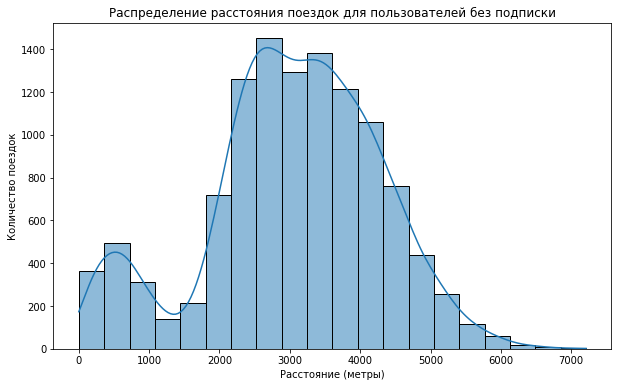

In [30]:
# Визуализация: Расстояние поездок для пользователей без подписки
plt.figure(figsize=(10, 6))
sns.histplot(no_subscription['distance'], bins=20, kde=True)
plt.title("Распределение расстояния поездок для пользователей без подписки")
plt.xlabel("Расстояние (метры)")
plt.ylabel("Количество поездок")
plt.show()

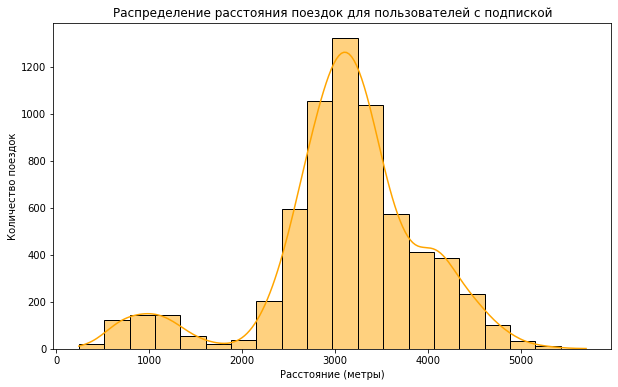

In [31]:
# Визуализация: Расстояние поездок для пользователей с подпиской
plt.figure(figsize=(10, 6))
sns.histplot(has_subscription['distance'], bins=20, kde=True, color="orange")
plt.title("Распределение расстояния поездок для пользователей с подпиской")
plt.xlabel("Расстояние (метры)")
plt.ylabel("Количество поездок")
plt.show()

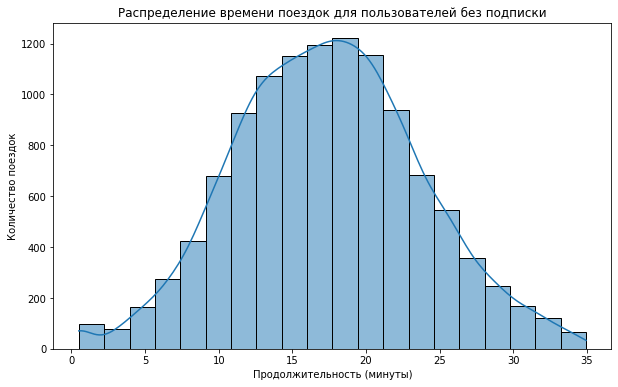

In [32]:
# Визуализация: Время поездок для пользователей без подписки
plt.figure(figsize=(10, 6))
sns.histplot(no_subscription['duration'], bins=20, kde=True)
plt.title("Распределение времени поездок для пользователей без подписки")
plt.xlabel("Продолжительность (минуты)")
plt.ylabel("Количество поездок")
plt.show()

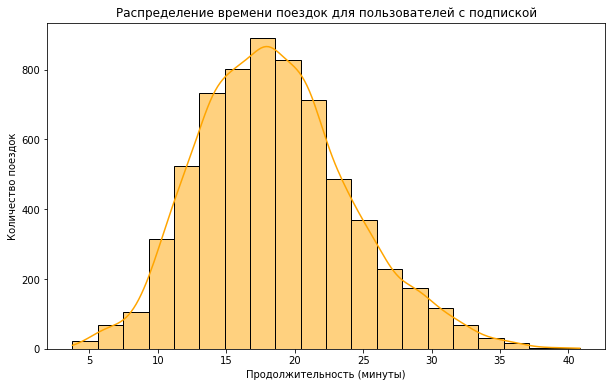

In [33]:
# Визуализация: Время поездок для пользователей с подпиской
plt.figure(figsize=(10, 6))
sns.histplot(has_subscription['duration'], bins=20, kde=True, color="orange")
plt.title("Распределение времени поездок для пользователей с подпиской")
plt.xlabel("Продолжительность (минуты)")
plt.ylabel("Количество поездок")
plt.show()

1. **Пользователи без подписки**:
    - Их распределение расстояний и времени поездок шире и выше, что указывает на более разнообразные паттерны использования. Некоторые из них, возможно, используют сервис для длинных поездок, не прибегая к подписке, и готовы платить за каждую минуту или километр отдельно.
    - Это также может свидетельствовать о том, что они менее ограничены в использовании сервиса по сравнению с подписчиками, так как нет фиксированной платы за подписку, и они платят по мере необходимости.
2. **Пользователи с подпиской**:
    - Эти пользователи предпочитают поездки на расстояние от 2,5 до 4 км, что занимает у них от 10 до 25 минут. Это может указывать на то, что подписка удобна для поездок средней дальности.
    - Вероятно, пользователи с подпиской ориентированы на более частые, но умеренные по продолжительности поездки, которые соответствуют условиям их подписки (бесплатный старт и сниженная стоимость за минуту).

##### Промежуточный вывод:

Анализ показал, что пользователи без подписки имеют более широкий диапазон расстояний и продолжительности поездок, возможно, потому что они менее ограничены и могут использовать сервис для более разнообразных поездок. В то же время пользователи с подпиской придерживаются среднего расстояния (около 2,5-4 км) и времени поездки (10-25 минут), что делает подписку для них экономически выгодной.

## Подсчёт выручки

### Агрегация данных о поездках

Начнем с группировки данных по `user_id` и `month`, чтобы получить общие показатели по расстоянию, количеству поездок и времени поездок для каждого пользователя в каждом месяце.
- `total_distance` — общее расстояние поездок.
- `total_rides` — количество поездок.
- `total_duration` — общее время поездок.

In [34]:
# Группировка данных по пользователям и месяцам
monthly_aggregates = all_data.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),       # Суммарное расстояние
    total_rides=('distance', 'count'),        # Количество поездок
    total_duration=('duration', 'sum')        # Суммарное время поездок
).reset_index()

# Просмотр результатов
monthly_aggregates.head()

,user_id,month,total_distance,total_rides,total_duration
0,1,1,7027.511294,2,41.416640
1,1,4,754.159807,1,6.232113
2,1,8,6723.470560,2,44.776802
3,1,10,5809.911100,2,31.578017
4,1,11,7003.499363,3,53.397424


In [35]:
# Ревьюеру для проверки.
pd.options.display.float_format = '{:,.1f}'.format
df_aggregated = monthly_aggregates
try:
    print('Length         11.331,', len(df_aggregated))
    print('Duration      330.708,', int(df_aggregated['sum_duration'].sum()))
    print('Distance   55.480.684,', int(df_aggregated['sum_distance'].sum()))
    print('Count          18.068,', int(df_aggregated['count_rides'].sum()))
    print('Revenue     3.878.641,', int(df_aggregated['monthly_revenue'].sum()))
except:
    print('Переименуй один из столбцов', df_aggregated.columns)
    print(df_aggregated.sum())

Length         11.331, 11331
Переименуй один из столбцов Index(['user_id', 'month', 'total_distance', 'total_rides', 'total_duration'], dtype='object')
user_id           9,190,134.0
month                73,397.0
total_distance   55,480,684.4
total_rides          18,068.0
total_duration      321,700.9
dtype: float64


### Подсчет помесячной выручки для каждого пользователя

Добавим расчет выручки, исходя из условий оплаты для пользователей с подпиской и без подписки.

Для этого используем такие условия:
- Пользователи без подписки оплачивают каждую минуту по 8 рублей и 50 рублей за начало каждой поездки.
- Пользователи с подпиской платят 199 рублей в месяц, 6 рублей за минуту и не платят за старт поездки.

In [36]:
# Объединяем с информацией о подписках, чтобы получить условия оплаты для каждого пользователя
revenue_data = monthly_aggregates.merge(all_data[['user_id', 'subscription_type', 'subscription_fee', 'minute_price', 'start_ride_price']].drop_duplicates(), on='user_id', how='left')

# Рассчитываем помесячную выручку с учетом условий подписки
revenue_data['monthly_revenue'] = (
    revenue_data['subscription_fee'] +                   # Ежемесячная плата за подписку
    revenue_data['total_duration'].apply(lambda x: round(x)) * revenue_data['minute_price'] +  # Стоимость минут поездок
    revenue_data['total_rides'] * revenue_data['start_ride_price']    # Стоимость начала поездок
)

# Просмотр результатов
revenue_data.head()

,user_id,month,total_distance,total_rides,total_duration,subscription_type,subscription_fee,minute_price,start_ride_price,monthly_revenue
0,1,1,"7,027.5",2,41.4,ultra,199,6,0,445
1,1,4,754.2,1,6.2,ultra,199,6,0,235
2,1,8,"6,723.5",2,44.8,ultra,199,6,0,469
3,1,10,"5,809.9",2,31.6,ultra,199,6,0,391
4,1,11,"7,003.5",3,53.4,ultra,199,6,0,517


Мы можем построить несколько графиков:

- **Гистограмма** для распределения месячной выручки среди всех пользователей.
- **Сравнительная гистограмма** для пользователей с подпиской и без подписки.
- **Средняя выручка по месяцам** для анализа сезонности, если такая информация полезна.

**1. Гистограмма для распределения месячной выручки среди всех пользователей**

Это поможет увидеть общее распределение выручки, а также выявить, есть ли какие-то аномально высокие значения.

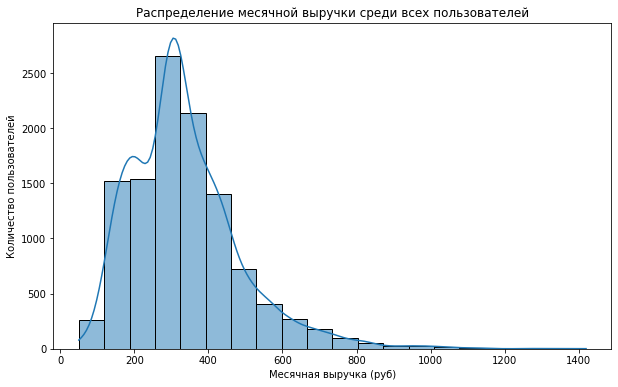

In [37]:
# Гистограмма для распределения месячной выручки среди всех пользователей
plt.figure(figsize=(10, 6))
sns.histplot(revenue_data['monthly_revenue'], bins=20, kde=True)
plt.title("Распределение месячной выручки среди всех пользователей")
plt.xlabel("Месячная выручка (руб)")
plt.ylabel("Количество пользователей")
plt.show()

1. **Левостороннее смещение**: Большинство пользователей генерируют относительно небольшую выручку. Это говорит о том, что большая часть пользователей, возможно, не использует сервис активно и совершает лишь несколько поездок в месяц или выбирает короткие поездки, которые не приносят значительного дохода.
2. **Пик около 300 рублей**: Большинство пользователей генерирует месячную выручку около 300 рублей, что выше стоимости подписки Ultra (199 рублей). Это может означать, что хотя многие пользователи предпочитают платить за поездки по базовому тарифу, их ежемесячные расходы иногда превышают стоимость подписки.
    - **Пользовательский паттерн**: Возможно, некоторые пользователи совершают поездки нерегулярно и полагают, что подписка им не нужна, хотя их расходы в итоге оказываются выше, чем если бы они оформили подписку.
    - **Недостаточная информированность**: Есть вероятность, что часть пользователей просто не осознает, что при их уровне использования подписка могла бы быть более выгодной.
3. **Длинный "хвост" вправо**: Некоторая часть пользователей все же генерирует значительно больше выручки, что может быть связано с частыми поездками и использованием сервиса для более длинных расстояний. Эти пользователи, вероятно, являются более активными, и, возможно, они чаще выбирают подписку.

Основная масса пользователей приносит сервису около 300 рублей в месяц, что указывает на нерегулярное использование. Однако длинный "хвост" вправо указывает на присутствие группы активных пользователей, которые генерируют более высокую выручку. Это распределение может послужить основой для дальнейшего анализа стратегии подписки и возможного введения дополнительных тарифов, чтобы лучше удовлетворить потребности как редких, так и частых пользователей.

**2. Сравнительная гистограмма для пользователей с подпиской и без подписки**

Построим две гистограммы на одном графике, чтобы сравнить выручку от подписчиков и неподписчиков. Это покажет, как подписка влияет на распределение выручки.

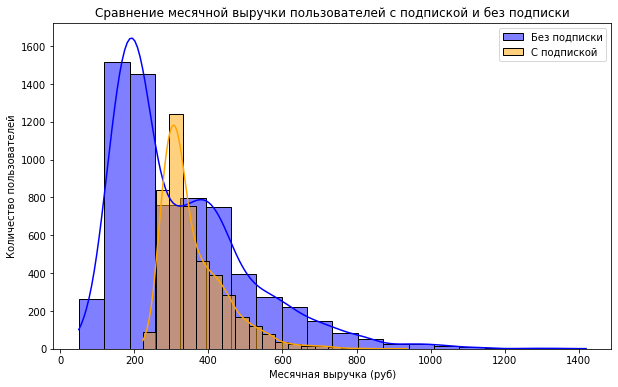

In [38]:
# Разделяем данные на две группы
revenue_no_subscription = revenue_data[revenue_data['subscription_type'] == 'free']
revenue_subscription = revenue_data[revenue_data['subscription_type'] == 'ultra']

# Сравнительная гистограмма
plt.figure(figsize=(10, 6))
sns.histplot(revenue_no_subscription['monthly_revenue'], bins=20, kde=True, color="blue", label="Без подписки")
sns.histplot(revenue_subscription['monthly_revenue'], bins=20, kde=True, color="orange", label="С подпиской")
plt.title("Сравнение месячной выручки пользователей с подпиской и без подписки")
plt.xlabel("Месячная выручка (руб)")
plt.ylabel("Количество пользователей")
plt.legend()
plt.show()

1. **Больше пользователей без подписки**: Количество пользователей без подписки заметно выше. Основная масса таких пользователей приносит примерно 200 рублей в месяц. Это может указывать на то, что большинство пользователей без подписки используют сервис нечасто или для коротких поездок, что приводит к относительно низкой месячной выручке.
2. **Пик для пользователей с подпиской**: Пик выручки для пользователей с подпиской находится на отметке около 300 рублей. Это выше, чем стоимость самой подписки (199 рублей), что указывает на то, что подписчики используют сервис достаточно активно, чтобы окупить подписку и принести дополнительный доход. Подписчики, возможно, ценят преимущества подписки, такие как отсутствие платы за старт и скидка на минуту поездки, и используют сервис чаще.
3. **Длинный "хвост" у пользователей без подписки**: Это указывает на наличие группы очень активных пользователей без подписки, которые генерируют высокую выручку, несмотря на отсутствие подписки. Это интересное наблюдение, так как оно показывает, что среди пользователей без подписки есть те, кто мог бы выиграть от ее оформления, особенно если их частые поездки приводят к значительным тратам.

Сравнение выручки пользователей с подпиской и без показало несколько интересных моментов. Пользователи без подписки составляют большинство и приносят меньшую выручку в среднем, однако среди них есть активные пользователи, которые генерируют высокий доход. Пользователи с подпиской приносят более стабильный доход, так как их расходы выше базовой стоимости подписки. Возможно, компании GoFast имеет смысл нацелиться на активных пользователей без подписки и предложить им выгодные условия для перехода на подписку, что может повысить их лояльность и увеличить общий доход.

**3. Средняя выручка по месяцам для анализа сезонности**

Проанализируем, есть ли сезонные колебания в выручке. Мы будем группировать данные по `month` и строить линию тренда.

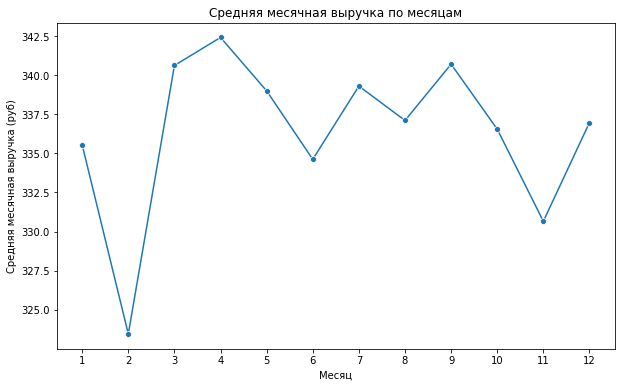

In [39]:
# Средняя выручка по месяцам
monthly_avg_revenue = revenue_data.groupby('month')['monthly_revenue'].mean()

# Линейный график средней выручки по месяцам
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg_revenue.index, y=monthly_avg_revenue.values, marker='o')
plt.title("Средняя месячная выручка по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Средняя месячная выручка (руб)")
plt.xticks(monthly_avg_revenue.index)
plt.show()

1. **Низкая выручка в феврале**: Февраль — короткий месяц и часто холодный. Вполне объяснимо, что у пользователей может наблюдаться сниженное желание пользоваться самокатами (но повышенное желание доставать чернил и плакать). Также низкая выручка может быть связана с возможными ошибками или неполными данными, так как провал в выручке, все же, выглядит подозрительным.
2. **Высокая выручка в апреле**: Этот всплеск вполне логичен. С приходом весны люди чаще выходят на улицу, и самокаты становятся более привлекательным видом транспорта. Вероятно, это момент, когда многие пользователи начинают активно пользоваться сервисом после зимнего затишья.
3. **Колебания в летние месяцы**: Спад в июне, затем новый пик в сентябре и снова спад — такие колебания, вероятно, также связаны с погодными условиями и сезонными изменениями в образе жизни. Летом многие люди уезжают в отпуска, что может объяснить падение активности в июне и июле. В сентябре активность снова возрастает с началом учебного и рабочего сезона.
4. **Спад в ноябре**: Как и в феврале может быть связан с погодными условиями. Однако, здесь мы не наблюдаем такого стремительного падения выручки, что может свидетельствовать о проблемных данных за февраль.
5. **Всплеск в декабре**: Этот всплеск может быть связан с предпраздничной суетой, когда город насыщен людьми, и самокаты могут стать удобным способом передвижения на фоне высокого автомобильного трафика.

### Промежуточный вывод

- Основная масса пользователей без подписки приносит выручку около 200 рублей, но есть небольшая группа активных пользователей, которые генерируют высокие доходы без подписки. Пользователи с подпиской стабильно приносят больше 300 рублей, что говорит о том, что они используют сервис более активно.
- Сезонные колебания выручки показали, что активность увеличивается весной, достигает пика в апреле и снова возрастает осенью, что связано с погодными условиями и изменениями в образе жизни. В декабре также наблюдается небольшой всплеск, который, вероятно, связан с предпраздничным периодом.

## Проверка гипотез

В этом шаге мы проверим три гипотезы, которые помогут ответить на вопросы бизнеса. Для каждой гипотезы будут сформулированы нулевая и альтернативная гипотезы.

### Гипотеза 1: Тратят ли пользователи с подпиской больше времени на поездки?

**Вопрос:** Тратят ли пользователи с подпиской больше времени на поездки?

**Нулевая гипотеза (Н0):** Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.

**Альтернативная гипотеза (Н1):** Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Для проверки этой гипотезы используем **двухвыборочный t-критерий Стьюдента** с аргументом `alternative='greater'`, чтобы учесть направление в альтернативной гипотезе.

In [40]:
# Разделяем данные на две группы
duration_no_subscription = all_data[all_data['subscription_type'] == 'free']['duration']
duration_subscription = all_data[all_data['subscription_type'] == 'ultra']['duration']

# Выполняем t-тест
t_stat, p_value = stats.ttest_ind(duration_subscription, duration_no_subscription,
                                  alternative='greater', equal_var=False)

print("t-статистика:", t_stat)
print("p-значение:", p_value)

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Разница статистически значима: пользователи с подпиской действительно тратят больше времени на поездки.")
else:
    print("Разница не является статистически значимой: пользователи с подпиской не тратят больше времени на поездки.")

t-статистика: 12.683043751946238
p-значение: 5.6757813771289775e-37
Разница статистически значима: пользователи с подпиской действительно тратят больше времени на поездки.


Пользователи с подпиской могут чувствовать себя более свободно в плане времени поездки, так как им не нужно платить за старт, и стоимость за минуту для них ниже. Это делает поездки для них более доступными и привлекательными для более длительного использования.

###  Гипотеза 2: Превышает ли среднее расстояние поездок пользователей с подпиской 3130 метров?

**Вопрос:** Превышает ли среднее расстояние, которое проезжают пользователи с подпиской, оптимальное значение в 3130 метров?

**Нулевая гипотеза (Н0):** Среднее расстояние поездок пользователей с подпиской не превышает 3130 метров.

**Альтернативная гипотеза (Н1):** Среднее расстояние поездок пользователей с подпиской превышает 3130 метров.

Для этой проверки используем одновыборочный t-тест с указанием, что альтернативная гипотеза направлена на превышение.

In [41]:
# Расстояния для пользователей с подпиской
distance_subscription = all_data[all_data['subscription_type'] == 'ultra']['distance']

# Выполняем t-тест для одной выборки
t_stat, p_value = stats.ttest_1samp(distance_subscription, 3130, alternative='greater')

print("t-статистика:", t_stat)
print("p-значение:", p_value)

# Интерпретация результата
if p_value < alpha and t_stat > 0:
    print("Среднее расстояние поездок пользователей с подпиской превышает 3130 метров.")
else:
    print("Среднее расстояние поездок пользователей с подпиской не превышает 3130 метров.")

t-статистика: -1.402123166869486
p-значение: 0.9195368847849785
Среднее расстояние поездок пользователей с подпиской не превышает 3130 метров.


Пользователи с подпиской, несмотря на более низкую стоимость поездок, не ездят на расстояния, значительно превышающие 3130 метров. Это может указывать на то, что даже подписчики используют самокаты для средних или коротких поездок, что, вероятно, связано с удобством и характером использования самокатов (для коротких поездок в черте города).

### Гипотеза 3: Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки?

**Вопрос:** Превышает ли помесячная выручка от пользователей с подпиской выручку от пользователей без подписки?

**Нулевая гипотеза (Н0):** Помесячная выручка от пользователей с подпиской равна или меньше выручки от пользователей без подписки.

**Альтернативная гипотеза (Н1):** Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Для этой гипотезы также применяем двухвыборочный t-критерий Стьюдента с направленной альтернативой.

In [42]:
# Помесячная выручка для пользователей без подписки и с подпиской
monthly_revenue_no_subscription = \
    revenue_data[revenue_data['subscription_type'] == 'free']['monthly_revenue']
monthly_revenue_subscription = \
    revenue_data[revenue_data['subscription_type'] == 'ultra']['monthly_revenue']

# Выполняем t-тест
t_stat, p_value = stats.ttest_ind(monthly_revenue_subscription, 
                                  monthly_revenue_no_subscription, alternative='greater',
                                  equal_var=False)

print("t-статистика:", t_stat)
print("p-значение:", p_value)

# Интерпретация результата
if p_value < alpha:
    print("Разница статистически значима: помесячная выручка от пользователей с подпиской выше.")
else:
    print("Разница не является статистически значимой: помесячная выручка от пользователей с подпиской не выше.")

t-статистика: 14.479039431068728
p-значение: 2.3492186178087955e-47
Разница статистически значима: помесячная выручка от пользователей с подпиской выше.


Пользователи с подпиской приносят компании GoFast более стабильный и высокий доход. Это подтверждает, что подписка не только выгодна пользователям, но и создает более предсказуемый и прибыльный источник дохода для компании.

##### Выбор теста для проверки гипотезы о снижении обращений в техподдержку

Предположим, что у нас есть данные о количестве обращений в техподдержку до и после обновления серверов. В этом случае мы можем использовать **парный t-тест**, так как у нас есть две связанные выборки (до и после) для одного и того же пользователя.
Предположим, что до и после обновления сохранены в списках (например, support_before и support_after)

```
# Выполняем парный t-тест
t_stat, p_value = stats.ttest_rel(support_before, support_after)

print("t-статистика:", t_stat)
print("p-значение:", p_value)

# Интерпретация результата
if p_value < alpha:
    print("Снижение количества обращений статистически значимо.")
else:
    print("Снижение количества обращений не является статистически значимым.")
```

##### Промежуточные выводы

Проверка гипотез показала:

- Пользователи с подпиской действительно проводят больше времени на поездках, что может быть связано с более выгодными условиями подписки (бесплатный старт и снижение стоимости за минуту).
- Среднее расстояние поездок подписчиков не превышает 3130 метров, что указывает на популярность самокатов для коротких и средних поездок.
- Помесячная выручка от пользователей с подпиской статистически значимо выше, чем от пользователей без подписки, что делает подписку выгодным инструментом как для пользователей, так и для компании.

Эти выводы подчеркивают важность продвижения подписки, так как она увеличивает время поездок и генерирует более высокий доход. На основе этих результатов компания GoFast может рассмотреть дополнительные стратегии для увеличения числа подписчиков и оптимизации выручки.

## Распределения

### Минимальное количество промокодов

Используем **биномиальное распределение**, так как нам нужно определить вероятность продления подписки (да/нет) для каждого пользователя, который получил промокод.

**Условия:**

- Вероятность продления подписки после пробного месяца: $p = 0.1$.
- Требуемое количество успешных продлений: 100.
- Необходимая вероятность выполнения плана (достичь 100 продлений): 95%.

Будем увеличивать количество разосланных промокодов $n$, пока вероятность достижения цели (100 продлений) не достигнет 95%.

In [43]:
p = 0.1  # Вероятность продления подписки
k = 100  # Требуемое количество продлений
target_probability = 0.95  # Целевая вероятность

# Поиск минимального количества промокодов
n = k
while True:
    # Вероятность получить менее 100 продлений из n
    probability = binom.cdf(k - 1, n, p)
    
    if probability < 1 - target_probability:
        break
    n += 1

print(f"Минимальное количество промокодов, которое нужно разослать: {n}")

Минимальное количество промокодов, которое нужно разослать: 1161


Результат в 1161 промокод выглядит реалистичным. Это означает, что для того, чтобы с вероятностью 95% как минимум 100 пользователей продлили подписку после пробного месяца, необходимо разослать 1161 промокод, учитывая, что вероятность продления составляет всего 10%.

Требуемое количество промокодов (1161) значительно выше 100, потому что вероятность продления подписки невелика (10%). Это говорит о том, что для достижения целевого количества продлений (100) требуется охватить гораздо большее число пользователей.

Разослать 1161 промокод — это стратегия, направленная на преодоление вероятности низкой конверсии, чтобы достичь необходимого уровня продлений.

### Вероятность того, что не более 399,500 уведомлений будет открыто из 1 млн разосланных

Здесь мы снова используем биномиальное распределение, так как каждое уведомление может быть либо открыто, либо нет. Однако, поскольку количество уведомлений велико, а вероятность открытия фиксирована, можно аппроксимировать биномиальное распределение **нормальным распределением** для упрощения расчетов.

**Условия:**

- Общее количество разосланных уведомлений: $n=1,000,000$.
- Вероятность открытия уведомления: $p=0.4$.
- Требуемое количество открытых уведомлений: не более 399,500.

In [44]:
# Условия задачи
n = 1000000  # Общее количество уведомлений
p = 0.4      # Вероятность открытия уведомления
k = 399500   # Ограничение на количество открытых уведомлений

# Параметры нормального распределения
mean = n * p
std_dev = (n * p * (1 - p)) ** 0.5

# Вычисление вероятности с использованием нормального распределения
probability = norm.cdf(k, mean, std_dev)

print(f"Вероятность того, что не более 399,500 уведомлений будет открыто: {probability:.4f}")

Вероятность того, что не более 399,500 уведомлений будет открыто: 0.1537


Вероятность того, что менее 399,500 уведомлений будет открыто, составляет лишь 15.37%, что говорит о том, что с гораздо большей вероятностью количество открытий будет превышать 399,500.

При 40%-ной вероятности открытия уведомления, в среднем можно ожидать около 400,000 открытий из 1 миллиона отправленных, что довольно близко к нашему пороговому значению 399,500. Однако низкая вероятность 0.1537 говорит о том, что значения ниже этого порога являются редкими.

Таким образом, маркетинговая команда может рассчитывать на то, что большинство кампаний с отправкой 1 млн уведомлений приведет к числу открытий, близкому или превышающему 399,500.

### Промежуточные выводы

В этом шаге мы провели анализ вероятностных распределений для двух важных задач маркетинговой команды GoFast, связанных с рассылками промокодов и push-уведомлений.

**1. Расчет минимального количества промокодов для достижения цели продлений**

- **Цель**: Обеспечить 100 продлений подписки с вероятностью 95%, учитывая, что средняя вероятность продления после пробного периода составляет 10%.
- **Результат**: Для того чтобы достичь цели, необходимо разослать **1161 промокод**.
- Достаточно высокая вероятность того, что пользователь не продлит подписку (90%) требует охвата большого количества пользователей, чтобы достигнуть необходимого уровня продлений. Это подчеркивает важность точного таргетинга при выборе аудитории для промокодов, чтобы повысить вероятность успеха.

**2. Оценка вероятности открытия push-уведомлений**

- **Цель**: Определить вероятность того, что не более 399,500 из 1 млн отправленных push-уведомлений будет открыто, если вероятность открытия составляет 40%.
- **Результат**: Вероятность того, что не более 399,500 уведомлений будет открыто, составила **15.37%**.
- Данная вероятность показывает, что в большинстве случаев количество открытых уведомлений будет превышать 399,500. Это означает, что маркетинговая команда может рассчитывать на относительно высокие уровни взаимодействия с push-уведомлениями, если вероятность открытия каждого уведомления остается на уровне 40%.

Эти результаты помогают компании принимать обоснованные решения в области маркетинга и оптимизировать ресурсы для достижения поставленных целей.

## Выводы

В рамках данного проекта мы провели комплексный анализ данных пользователей и их взаимодействия с сервисом GoFast. В ходе работы были выполнены несколько ключевых шагов, направленных на исследование поведения клиентов, оценку выручки и проверку гипотез для поддержки маркетинговых и продуктовых решений.

### Основные итоги работы

1. **Анализ данных пользователей и поездок**:
    - Мы выявили, что наибольшая часть пользователей сервиса находится в Пятигорске, а наименьшая — в Москве, что может сигнализировать о возможности расширения в крупные города.
    - Основная целевая аудитория сервиса — молодые люди в возрасте от 20 до 30 лет, что позволяет GoFast лучше ориентировать свои маркетинговые кампании.
    - Пики расстояний поездок находятся около 500 метров и 3 км, что показывает, что пользователи часто используют сервис как для коротких, так и для умеренно длинных поездок.
2. **Сравнение пользователей с подпиской и без подписки**:
    - Пользователи с подпиской проводят больше времени на поездках и генерируют более стабильную выручку для компании, тогда как пользователи без подписки приносят меньше дохода, но среди них есть активные пользователи, которые могли бы выиграть от подписки.
    - Это открывает возможности для продвижения подписки среди активных пользователей без подписки, что может привести к повышению доходов.
3. **Анализ выручки и сезонных колебаний**:
    - Основная масса пользователей приносит месячную выручку около 300 рублей, что немного превышает стоимость подписки. Это указывает на потенциальный интерес пользователей к подписке, если они поймут ее выгоды.
    - Сезонные колебания показали, что выручка возрастает весной и осенью, а также наблюдается пик в декабре, вероятно, из-за предпраздничной активности. Понимание сезонности позволяет планировать маркетинговые активности в периоды высокой и низкой активности пользователей.
4. **Проверка гипотез**:
    - Гипотезы показали, что пользователи с подпиской проводят больше времени в поездках и приносят больше месячной выручки, однако среднее расстояние их поездок не превышает 3130 метров.
    - Это знание позволяет компании более эффективно адаптировать предложения для обеих категорий пользователей, например, предлагая подписку с акцентом на частоту и продолжительность поездок.
5. **Анализ вероятностей и распределений для маркетинговых задач**:
    - Для обеспечения 100 продлений подписки с вероятностью 95% необходимо разослать 1161 промокод, что подчеркивает важность охвата большой аудитории для достижения целей с низкой вероятностью конверсии.
    - Вероятность того, что из 1 млн разосланных push-уведомлений не более 399,500 будет открыто, составляет 15.37%, что указывает на высокую вероятность открытия уведомлений, если вероятность открытия каждого составляет 40%.

### Общий вывод

Анализ данных, проведенный в этом проекте, предоставил GoFast ценные инсайты о поведении пользователей, выручке и возможности для увеличения подписок и улучшения маркетинговых стратегий. Эти данные позволяют компании:

- Разрабатывать таргетированные маркетинговые кампании с учетом особенностей целевой аудитории и сезонных колебаний.
- Привлекать активных пользователей без подписки, предлагая им персонализированные условия для перехода на подписку.
- Оптимально распределять ресурсы для рассылок промокодов и push-уведомлений, опираясь на вероятностные оценки.